In [1]:
# modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import chardet
import csv
import os
import matplotlib.dates as mdates
from IPython.display import Image

## Inserez les chemins vers le fichiers CSV:

In [2]:
# on récupère les informations du dossier
dossier = './raw_data'
contenuDossier = os.listdir(dossier)
print(contenuDossier)
nombrePoints = 0
nomPoints = []
numeroPoints = []
# on parcours le dossier en recherchant les fichiers des points
for x in contenuDossier:
    if x.startswith('point'):
        nombrePoints += 1
        nomPoints.append(x)
        numeroPoints.append(x[5:7])
print(numeroPoints)

['point14_29_07_15', 'point15_29_07_15', '.DS_Store', 'schema_dispositif_AvAv_23_07_15.png', 'Point034', 'point13_29_07_15']
['14', '15', '13']


In [3]:
def read_csv (chemin_fichier):
    #Detecter separateur
    with open(chemin_fichier, 'r') as file:
        sniffer = csv.Sniffer()
        sample_data = file.read(1024)
        detecter_separateur = (sniffer.sniff(sample_data).delimiter)

    if "Titre" in open(chemin_fichier).readline():
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur, skiprows=1)
    else:
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur)

    return data_frame 

In [4]:
# on crée un dictionnaire avec toutes les informations pour chaque point et on met les dictionnaires dans une liste
data = []
for x in nomPoints :
    dico = {}
    # le numéro
    dico['numero'] = x[5:7]
    # le nom
    dico['nom'] = x
    # la date
    dico['date'] = x[8:18]
    # le chemin vers le dossier
    dico['chemin'] = dossier + '/' + x
    with open(dico['chemin'] + '/geometrie.txt', 'r') as fichier:
        lignes = fichier.readlines()
        # le nom du capteur
        dico['capteur'] = lignes[1][:4]
        # la profondeur du capteur
        if lignes[3] == '\n' :
            dico['profondeur'] = 0
        else : 
            dico['profondeur'] = lignes[3]
        # les profondeurs auquelles on fait les mesures
        dico['profondeurMesures'] = []
        profMes = lignes[5].split(';')
        for num in profMes :
            dico['profondeurMesures'].append(int(num))
    # on va ensuite mettre les dataframes dans le dictionnaire
    contenuDossierPoint = os.listdir(dico['chemin'])
    for x in contenuDossierPoint:
        # la pression
        if x.startswith('p') and x.endswith('.csv'):
            dico['pression'] = read_csv(dico['chemin'] + '/' + x)
        # la température
        if x.startswith('t') and x.endswith('.csv'):
            dico['temperature'] = read_csv(dico['chemin'] + '/' + x)
    # dans les configurations du capteur on va chercher les données
    with open('configuration/pressure_sensors/P' + '505' +'.csv' ) as fichier :
        # normalement il faut mettre dico['capteur'][1:] pas '505' mais là on a pas les fichiers :/
        lignes = fichier.readlines()
        for l in lignes :
            if l.startswith('Intercept') :
                dico['intercept'] = float(l[10:-2])
            if l.startswith('dU/dH') :
                dico['dU/dH'] = float(l[6:-2])
            if l.startswith('dU/dT') :
                dico['dU/dT'] = float(l[6:-2]) 
    data.append(dico)


In [5]:
# en faisant data[0] on a accès à toutes les informations du point 1
data[0]

{'numero': '14',
 'nom': 'point14_29_07_15',
 'date': '29_07_15',
 'chemin': './raw_data/point14_29_07_15',
 'capteur': 'p507',
 'profondeur': 0,
 'profondeurMesures': [10, 20, 30, 40],
 'pression':        #  Date Heure GMT+02:00  \
 0      1  07/23/15 02:00:00 PM   
 1      2  07/23/15 02:15:00 PM   
 2      3  07/23/15 02:30:00 PM   
 3      4  07/23/15 02:45:00 PM   
 4      5  07/23/15 03:00:00 PM   
 ..   ...                   ...   
 558  559  07/29/15 09:30:00 AM   
 559  560  07/29/15 09:45:00 AM   
 560  561  07/29/15 10:00:00 AM   
 561  562  07/29/15 10:15:00 AM   
 562  563  07/29/15 10:30:00 AM   
 
      Tension V (LGR S/N: 10614065 SEN S/N: 10614065)  \
 0                                            0.01183   
 1                                            0.00080   
 2                                            0.00080   
 3                                            0.00092   
 4                                            0.00088   
 ..                                   

### On modifie les nom des colonnes du dataframe

In [6]:
# pour les températures
for x in data :
    # on supprime la première colonne si elle ne sert à rien
    for i in x['temperature'].columns :
        if not( i.startswith('Date') or i.startswith('Temp')) :
            del x['temperature'][i]
    for i in x['pression'].columns :
        if not( i.startswith('Date') or i.startswith('Tension') or i.startswith('Temp')) :
            del x['pression'][i]
    # on renomme les colonnes
    profondeur = x['profondeurMesures']
    colonnesT = ['dates']
    for num in profondeur :
        colonnesT.append('Temp_profondeur_'+ str(num))
    x['temperature'].columns = colonnesT
    colonnesP = ['dates', 'tension', 'temperature_stream']
    x['pression'].columns = colonnesP
    

In [7]:
# notamment la température et la pression
data[0]['temperature'].head(5)

,dates,Temp_profondeur_10,Temp_profondeur_20,Temp_profondeur_30,Temp_profondeur_40
0,07/23/15 02:00:00 PM,26.207,27.554,26.378,28.097
1,07/23/15 02:15:00 PM,28.147,27.087,26.867,29.265
2,07/23/15 02:30:00 PM,28.419,28.543,27.431,29.615
3,07/23/15 02:45:00 PM,18.390,21.223,18.319,19.555
4,07/23/15 03:00:00 PM,18.509,21.318,18.461,19.413


### Création du fichier `info.txt`

In [8]:
# Ouvrez un fichier en mode écriture ('w')
for x in data :
    if os.path.exists(x['chemin'] + '/point' + x['numero'] + '_info.txt') :
        os.remove(x['chemin'] + '/point' + x['numero'] + '_info.txt')
    with open(x['chemin'] + '/point' + x['numero'] + '_info.txt', 'w') as fichier:
        # Parcourez le dictionnaire et écrivez les données dans le fichier
        fichier.write('Point_Name,Point' + x['numero'] + '\n')
        fichier.write('P_Sensor_Name,' + x['capteur'] + '\n')
        fichier.write('Implantation_Date,' + x['date'] + '\n')
        fichier.write('Meas_date, \n')
        fichier.write('River_Deb,' + '\n')
        fichier.write('Delta_h,' + '\n')


la suite est à adapter

In [9]:
# Conversion dans le bon format date
for point in data:
    point['pression']['dates'] = pd.to_datetime(point['pression']['dates'], format='%m/%d/%y %I:%M:%S %p')
    point['temperature']['dates'] = pd.to_datetime(point['temperature']['dates'], format='%m/%d/%y %I:%M:%S %p')

In [10]:
data[0]['temperature'].head(5)

,dates,Temp_profondeur_10,Temp_profondeur_20,Temp_profondeur_30,Temp_profondeur_40
0,2015-07-23 14:00:00,26.207,27.554,26.378,28.097
1,2015-07-23 14:15:00,28.147,27.087,26.867,29.265
2,2015-07-23 14:30:00,28.419,28.543,27.431,29.615
3,2015-07-23 14:45:00,18.390,21.223,18.319,19.555
4,2015-07-23 15:00:00,18.509,21.318,18.461,19.413


In [11]:
def nombre_de_valeurs_manquantes(capteur):
    # Compte des valeurs manquantes (NaN) pour chaque colonne
    nombre_de_valeurs_manquantes = capteur.isna().sum()
    return nombre_de_valeurs_manquantes

# Exemple d'utilisation :
nombre_valeurs_manquantes_pression = nombre_de_valeurs_manquantes(point['pression'])
nombre_valeurs_manquantes_temperature = nombre_de_valeurs_manquantes(point['temperature'])

print("Nombre de valeurs manquantes pour la pression :")
print(nombre_valeurs_manquantes_pression)

print("\nNombre de valeurs manquantes pour la température :")
print(nombre_valeurs_manquantes_temperature)

Nombre de valeurs manquantes pour la pression :
dates                 0
tension               0
temperature_stream    0
dtype: int64

Nombre de valeurs manquantes pour la température :
dates                 0
Temp_profondeur_10    0
Temp_profondeur_20    0
Temp_profondeur_30    0
Temp_profondeur_40    0
dtype: int64


In [20]:
for point in data:
    k0 = float(point['intercept'])
    k1 = float(point['dU/dH'])
    k2 = float(point['dU/dT'])
    
    # Calcul de la colonne 'dH' en utilisant la formule H = 1/k1 * (U - k0 - k2 * T)
    U = point['pression']['tension'].astype(float)
    T = point['pression']['temperature_stream'].astype(float)
    point['pression']['dH'] = (1 / k1) * (U - k0 - k2 * T)

data[0]['pression']

,dates,tension,temperature_stream,dH
0,2015-07-23 14:00:00,0.01183,45.230,0.108139
1,2015-07-23 14:15:00,0.00080,21.979,0.145134
2,2015-07-23 14:30:00,0.00080,21.609,0.145703
3,2015-07-23 14:45:00,0.00092,21.910,0.145227
4,2015-07-23 15:00:00,0.00088,20.966,0.146683
...,...,...,...,...
558,2015-07-29 09:30:00,1.23991,15.562,0.015771
559,2015-07-29 09:45:00,1.23709,15.541,0.016120
560,2015-07-29 10:00:00,1.24273,15.513,0.015530
561,2015-07-29 10:15:00,1.24022,15.599,0.015679


In [12]:
from scipy import stats
# Traiter chaque colonne sauf la colonne des dates
columns_to_process = [col for col in data[0]['pression'].columns if col != "dates"]

# Créer un DataFrame vide pour stocker les données traitées
df_processed2 = data[0]['pression'][["dates"]].copy()

# Boucler à travers chaque colonne à traiter
for column_name in columns_to_process:
    # Calculer le Z-score pour la colonne
    z_scores = np.abs(stats.zscore(data[0]['pression'][column_name]))
    
    # Définir un seuil pour le Z-score (par exemple, 3)
    threshold = 3
    # Sélectionner les lignes avec des Z-scores inférieurs au seuil
    df_cleaned = data[0]['pression'][z_scores < threshold]
    
    # Copier les données traitées dans df_processed
    df_processed2[column_name] = df_cleaned[column_name]

# Afficher les statistiques des données traitées
print(df_processed2.describe())

          tension  temperature_stream
count  557.000000          558.000000
mean     1.260235           16.267339
std      0.031142            0.584637
min      1.133360           15.372000
25%      1.236630           15.799000
50%      1.253720           16.159000
75%      1.275460           16.687000
max      1.342260           19.928000


## Traitement des données pluie et température de l'air

                 DateHeure  Valeur Qualite  Min  Max
823    1993-08-04 06:00:00     0.0       v  NaN  NaN
824    1993-08-04 07:00:00     0.0       v  NaN  NaN
825    1993-08-04 08:00:00     0.0       v  NaN  NaN
826    1993-08-04 09:00:00     0.0       v  NaN  NaN
827    1993-08-04 10:00:00     0.0       v  NaN  NaN
...                    ...     ...     ...  ...  ...
256462 2022-10-02 21:00:00     0.0       v  NaN  NaN
256463 2022-10-02 22:00:00     0.0       v  NaN  NaN
256547 2022-10-06 10:00:00     0.0       v  NaN  NaN
256553 2022-10-06 16:00:00     0.2       v  NaN  NaN
256595 2022-10-08 10:00:00     0.0       v  NaN  NaN

[215954 rows x 5 columns]
                 DateHeure  Valeur Qualite  Min  Max
0      1993-06-30 23:00:00    15.2       v  NaN  NaN
6      1993-07-01 05:00:00    14.9       v  NaN  NaN
7      1993-07-01 06:00:00    16.5       v  NaN  NaN
9      1993-07-01 08:00:00    22.0       v  NaN  NaN
12     1993-07-01 11:00:00    23.5       v  NaN  NaN
...                

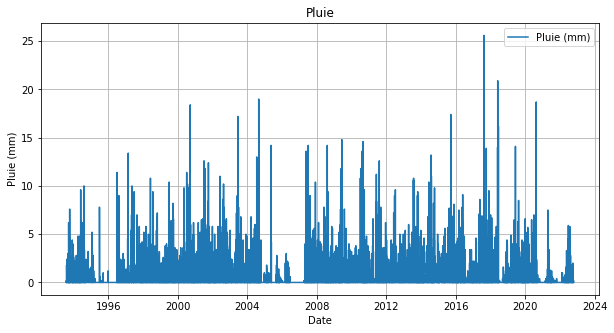

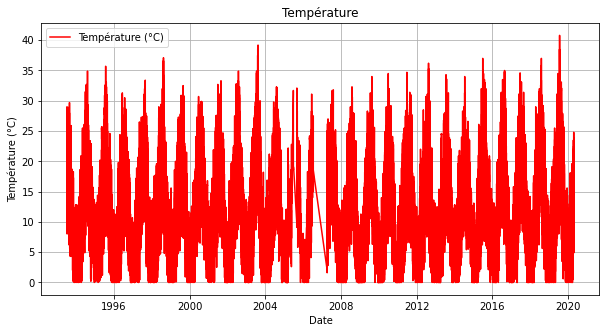

In [14]:
import pandas as pd
import csv
import matplotlib.pyplot as plt

pluie = pd.read_csv('Meteo/BOISSY-METEO_PRCP.txt', sep=';', skiprows=2)
temp = pd.read_csv('Meteo/BOISSY-METEO_TEMPA.txt', sep=';', skiprows=2)

pluie['DateHeure'] = pd.to_datetime(pluie['DateHeure'], format='%d/%m/%Y %H:%M:%S')
temp['DateHeure'] = pd.to_datetime(temp['DateHeure'], format='%d/%m/%Y %H:%M:%S')

pluie = pluie[pluie['Valeur'] >= 0]
temp = temp[temp['Valeur'] >= 0]

print(pluie)
print(temp)

# Tracé de la pluie
plt.figure(figsize=(10, 5))
plt.plot(pluie['DateHeure'], pluie['Valeur'], label='Pluie (mm)')
plt.title('Pluie')
plt.xlabel('Date')
plt.ylabel('Pluie (mm)')
plt.grid(True)
plt.legend()
plt.show()

# Tracé de la température
plt.figure(figsize=(10, 5))
plt.plot(temp['DateHeure'], temp['Valeur'], color='red', label='Température (°C)')
plt.title('Température')
plt.xlabel('Date')
plt.ylabel('Température (°C)')
plt.grid(True)
plt.legend()
plt.show()

Inflitrant
Exfiltrant


Text(0.5, 1.0, 'Régime selon les précipitations')

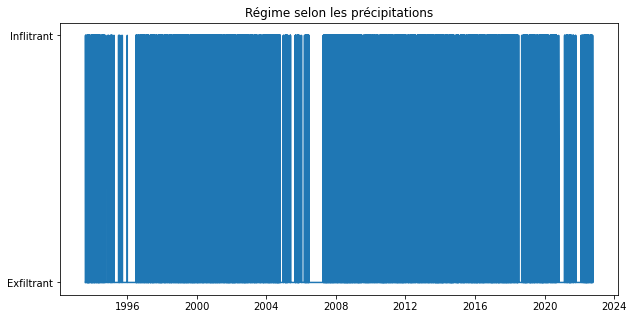

In [18]:
#Fonction qui donne le régime selon les précipitations
def classifier_pluie(valeur):
    if valeur <= 0:
        return "Exfiltrant"
    else:
        return "Inflitrant"

# Test
print(classifier_pluie(0.1))
print(classifier_pluie(-0.1))

# Graphe qui montre le régime selon les précipitations
plt.figure(figsize=(10, 5))
plt.plot(pluie['DateHeure'], pluie['Valeur'].apply(classifier_pluie), label='Régime')
plt.title('Régime selon les précipitations')

In [21]:
data[0]['pression']['dH']

0      0.108139
1      0.145134
2      0.145703
3      0.145227
4      0.146683
         ...   
558    0.015771
559    0.016120
560    0.015530
561    0.015679
562    0.001929
Name: dH, Length: 563, dtype: float64

In [24]:
def verifier_regime(dH):
    if dH > 0:
        return "Infiltrant"
    else:
        return "Exfiltrant"
    
# Test
dH = -0.5
regime = verifier_regime(dH)
print(regime)

Exfiltrant


Text(0.5, 1.0, 'Régime')

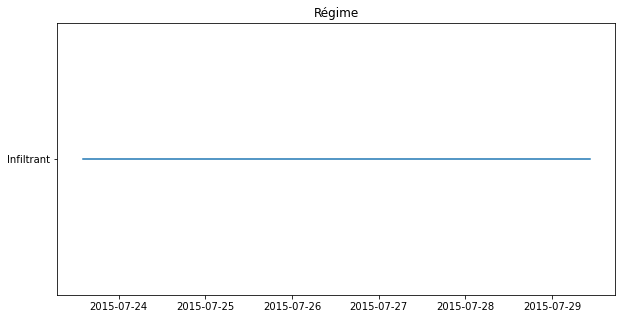

In [28]:
# Ajout d'une colonne 'regime' dans le DataFrame
data[0]['pression']['regime'] = data[0]['pression']['dH'].apply(verifier_regime)

# Tracé du régime
plt.figure(figsize=(10, 5))
plt.plot(data[0]['pression']['dates'], data[0]['pression']['regime'], label='Régime')
plt.title('Régime')

In [31]:
# Indiquer le nombre de valeurs négatives de dH
print((data[0]['pression']['dH'] < 0).sum())

0
